In [137]:
import pandas as pd
import numpy as np
import pickle
from datetime import datetime
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d
from scipy.interpolate import splrep
import warnings
warnings.simplefilter(action='ignore')
import matplotlib.pyplot as plt
%matplotlib inline

In [143]:
with open('../../output/cv_df_list_prospective_monthly.pkl', 'rb') as file:
    data_file = pickle.load(file)

k = 9
prov = 10

input_data = data_file[k]
input_data['year_month'] = (input_data['date_sick_year']-2006)*12 + (input_data['month'])

df = input_data.loc[input_data['province'] == prov]
df.head()

,date_sick_year,month,province,cases,date_sick,year_month
38753,2006,1,10,437.0,2006-1-1,1
38823,2006,2,10,319.0,2006-2-1,2
38891,2006,3,10,371.0,2006-3-1,3
38962,2006,4,10,198.0,2006-4-1,4
39037,2006,5,10,735.0,2006-5-1,5


### First Approach:

ie. smooth, then average

1. Fit a smoothing spline to the data for the entirety of the number of years (time interval of 12+ months)
2. Find the smoothed/fitted values for each month and add as a new column to the dataframe `(smooth_cases)`
3. Using these smoothed values, find the average value for each month

Those average values for each month are the predictions for the next year.

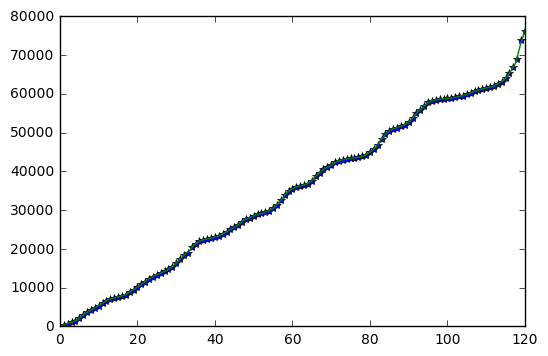

In [188]:
x = df['year_month'].tolist()
y = df['cases'].tolist()

y_sum = np.cumsum(y)

spl = UnivariateSpline(x, y_sum)
plt.plot(x, y_sum, '*', xnew, spl(xnew), '-')

In [189]:
# get the predicted values and add to the dataframe

y_fit = spl(x)

y_smooth = np.diff(y_fit)
n = np.append(y_smooth[::-1], y_sum[0])
y_smooth = n[::-1]

df['smooth_cases'] = y_smooth

df.head()

,date_sick_year,month,province,cases,date_sick,year_month,smooth_cases
38753,2006,1,10,437.0,2006-1-1,1,437.000000
38823,2006,2,10,319.0,2006-2-1,2,319.006615
38891,2006,3,10,371.0,2006-3-1,3,370.981973
38962,2006,4,10,198.0,2006-4-1,4,198.028150
39037,2006,5,10,735.0,2006-5-1,5,734.971661


In [191]:
# now get the averages for each month
# currently this only works for one month ahead

monthly_avg = []
for i in range(1, 13):
    monthly_cases = df['smooth_cases'].loc[df['month'] == i].tolist()
    avg = np.mean(monthly_cases)
    monthly_avg.append(avg)

print(monthly_avg)

# monthly_avg is the predictions

[437.58987246824472, 301.46740906466317, 292.58358413655986, 259.0740310963032, 417.81285083781677, 596.00017935228482, 719.83650192048549, 827.00372943711807, 752.56273711128756, 961.68530854458515, 1280.3612509967793, 788.72813171141911]


### Second Approach

ie. average then smooth

1. Find the average number of cases for each month
2. Smooth the average values for each month (time interval of strictly 12 months)
3. Get the smoothed/fitted average values for each month

These are the predictions for the next year.

In [192]:
# now try finding the average value for each month
# fitting a spline to the monthly averages (lose years)
# then get the fitted values for each month

# start by getting the monthly averages
monthly_avg2 = []
for i in range(1, 13):
    monthly_cases = df['cases'].loc[df['month'] == i].tolist()
    avg = np.mean(monthly_cases)
    monthly_avg2.append(avg)
    
# monthly_avg2 is the "true" monthly averages

[  437.5          302.25334334   290.8536056    261.15577502   416.78529476
   594.79149355   723.50185493   822.37489368   755.2108737    962.37191041
  1278.28850541   789.95961593]


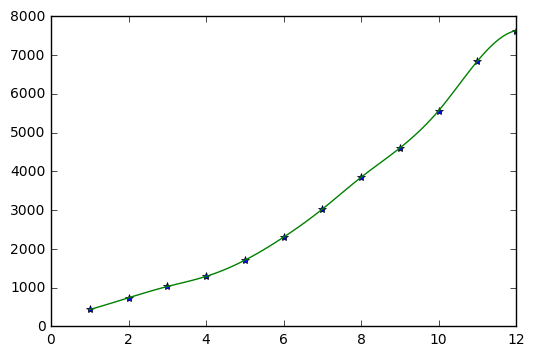

In [193]:
# get the fitted values
x2 = np.arange(1, 13)
y_sum2 = np.cumsum(monthly_avg2)
xnew2 = np.linspace(1, 12, num=100, endpoint=True)

spl2 = UnivariateSpline(x2, y_sum2)
plt.plot(x2, y_sum2, '*', xnew2, spl2(xnew2), '-')

y_fit2 = spl2(x2)
y_smooth2 = np.diff(y_fit2)
m = np.append(y_smooth2[::-1], y_sum2[0])
y_smooth2 = m[::-1]

print(y_smooth2)

# y_smooth2 are the predictions

### Comparing Approaches

In [194]:
# now compare the two approaches

diff_in_approaches = abs(monthly_avg - y_smooth2)
print(diff_in_approaches)

[ 0.08987247  0.78593428  1.72997854  2.08174393  1.02755608  1.2086858
  3.66535301  4.62883576  2.64813659  0.68660186  2.07274559  1.23148422]


In [196]:
true_avg_vs_first_approach = abs(np.array(monthly_avg) - np.array(monthly_avg2))
print(true_avg_vs_first_approach)

[  8.98724682e-02   2.32590935e-01   3.83584137e-01   4.25968904e-01
   3.12850838e-01   1.79352285e-04   5.63498080e-01   1.10372944e+00
   1.13726289e+00   6.85308545e-01   2.38749003e-01   2.81317114e-02]


In [197]:
true_avg_vs_second_approach = abs(np.array(y_smooth2) - np.array(monthly_avg2))
print(true_avg_vs_second_approach)

[ 0.          0.55334334  1.3463944   1.65577502  0.71470524  1.20850645
  3.10185493  3.52510632  1.5108737   1.37191041  2.31149459  1.25961593]


In [ ]:

'''
input_data['date_sick'] = pd.to_datetime(input_data['date_sick'])

data = pd.DataFrame({'date_sick': input_data['date_sick'], 'cases': input_data['cases']})
data = data.set_index('date_sick')

data

plt.plot(data)
'''